 # 1. Setup and Initializations

In [191]:
import copy
import os
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import random
from PIL import Image
import warnings
import time
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings
warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
_base_model = "vit_base_patch16_224"
_data_path = "data/EDC"
_tranform_rules = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

# Use DataLoader to load the dataset (json includes the first value as the path to the image and the second value as the label)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, json_data, label_map, custom_transform=None):
        self.data = json_data
        self.label_map = label_map
        self.transform = _tranform_rules
        if custom_transform:
            self.transform = custom_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_sub_path, label = self.data[idx]
        img_path = os.path.join("data", img_sub_path)
        image = Image.open(img_path).convert("RGB")

        # Transform the images
        image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(self.label_map[label], dtype=torch.long)

        return image, label

def create_model(name=_base_model, pretrained=True, classes=4, state_dict=None):
    model = timm.create_model(name, pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, classes)
    if not pretrained:
        state_dict = torch.load(state_dict, map_location="cpu")
        model.load_state_dict(state_dict)
    return model

# ------------------
# Dataset Functions
# ------------------
def split_dataset(data_path, train_percent=0.7):
    # Split the dataset into train, val, and test sets (4 directories, one for each class. Combine all directories after splitting)
    train, val, test = [], [], []
    val_percent = ((1-train_percent)) / 2

    for dir in os.listdir(data_path):
        # Skip non directories
        if not os.path.isdir(os.path.join(data_path, dir)):
            continue
        dir_path = os.path.join(data_path, dir)
        dir_json_path = os.path.join(dir_path, "data.json")
        data = json.load(open(dir_json_path, "r"))

        # Randomly split the data into train, val, and test sets.
        shuffled_data = data.copy()
        random.shuffle(shuffled_data)

        train_size = int(train_percent * len(shuffled_data))
        val_size = int(val_percent * len(shuffled_data))

        train_data = shuffled_data[:train_size]
        val_data = shuffled_data[train_size:train_size + val_size]
        test_data = shuffled_data[train_size + val_size:]

        # Add each item in train_data to train
        for item in train_data:
            train.append(item)

        for item in val_data:
            val.append(item)

        for item in test_data:
            test.append(item)

    # Save the split data into separate JSON files
    with open(os.path.join(data_path, "train.json"), "w") as f:
        json.dump(train, f)
    with open(os.path.join(data_path, "val.json"), "w") as f:
        json.dump(val, f)
    with open(os.path.join(data_path, "test.json"), "w") as f:
        json.dump(test, f)

    # Print length of each set
    print(f"Train set size: {len(train)}")
    print(f"Validation set size: {len(val)}")
    print(f"Test set size: {len(test)}")

def get_loaders(base_path, label_map, batch_size):
    # Load the dataset
    train_json = json.load(open(os.path.join(base_path, "train.json"), "r"))
    val_json = json.load(open(os.path.join(base_path, "val.json"), "r"))
    test_json = json.load(open(os.path.join(base_path, "test.json"), "r"))

    train_dataset= CustomDataset(train_json, label_map=label_map)
    val_dataset= CustomDataset(val_json, label_map=label_map)
    test_dataset= CustomDataset(test_json, label_map=label_map)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# -------------------
# Training Functions
# -------------------
def train_model(model, epochs, lr, train_loader, val_loader):
    start_time = time.time()
    # Prepare learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Move model to be in same place as training
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            # Fix for monai models
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Validation loop
        accuracy, _, _ = test_model(model, val_loader, print_results=False)
        print(f"Epoch {epoch+1}/{epochs} completed. | Loss: {loss.item():.4f} | Accuracy: {accuracy:.2f}% | elapsed time: {time.time() - epoch_start_time:.2f} seconds")

        # TODO: Consider adding this in to save the best model even if it trains in less epochs that desired.
        # This could be useful for early stopping, may change how I write the report, but come back to this for further research.
        # Save the model if it is the best so far
        # if epoch == 0 or accuracy > best_accuracy:
        #     best_accuracy = accuracy
        #     torch.save(model.state_dict(), f'{model_name}_best_model_({accuracy:.2f}).pth')

    print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

def test_model(model, test_loader, print_results=True):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Fix for monai models
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    # Evaluation metrics (precision, recall, f1-score, support) for each class
    report = classification_report(all_labels, all_preds, target_names=["Normal", "Cataract", "Diabetic Retinopathy", "Glaucoma"], output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    if print_results:
        print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy, report, cm

def free_up_memory(models:list=None):
    if models is not None:
        for model in models:
            del model # unload models
    torch.cuda.empty_cache() # Clear cache state to make each lr run independent
    torch.cuda.synchronize() # Wait for all kernels in all streams on a device to finish (may not need, but why not right?)

def train_and_test_on_model(model, lrs: list, batch_size: int, epochs: int, train_percent=0.7, data_path=_data_path, new_dataset_split=True, freeze_layers=[""], runs=1):
    label_map = {
        "n": 0, # Normal
        "c": 1, # Cataract
        "d": 2, # Diabetic Retinopathy
        "g": 3  # Glaucoma
    }
    best_accuracy = 0

    # Copy of the model to reload between runs
    clean_model = copy.deepcopy(model.state_dict())

    # Split dataset (can be disabled to test on same set once it's been done once)
    if new_dataset_split:
        split_dataset(data_path, train_percent=train_percent) # Turn this off to reuse the same dataset split

    # Get Loaders
    train_loader, val_loader, test_loader = get_loaders(data_path, label_map=label_map, batch_size=batch_size)
    first_run = True

    # Run for each lr & frozen layer combo
    for i in range(runs):
        print(f"Running run {i+1}/{runs}\n---------------------")
        for lr in lrs:
            if first_run:
                test_model(model, test_loader)    # Test the model before training
                first_run = False
            print("---------------------\n\n---------------------")
            for blocks in freeze_layers:
                # Reload the model to reset it
                model.load_state_dict(clean_model)
                free_up_memory() # Clean up memory before each run

                # Freeze subset of blocks
                for name, param in model.named_parameters():
                    if name in blocks:
                        param.requires_grad = False
                    else:
                        param.requires_grad = True

                print(f"Training model on learning rate: {lr} | batch size: {batch_size} | epochs: {epochs} | Frozen Layers: {len(blocks)}")
                train_model(model, epochs, lr, train_loader, val_loader)

                # Get metrics for run.
                acc, _, _ = test_model(model, test_loader)
                hyps = ({"LR" : lr}, {"batch_size":batch_size}, {"epochs": epochs})
                modl = ({"freeze_layers": len(blocks)}, {"accuracy": acc})
                metric = ({"hyperparameters": hyps}, {"model": modl})

                with open(f'metrics.json', 'a') as f:
                    json.dump(metric, f)
                    f.write('\n')

                # Save model with best accuracy
                if acc > best_accuracy:
                    best_accuracy = acc
                    torch.save(model.state_dict(), f'best_vit_model_lr{lr}_b{batch_size}_e{epochs}_acc{acc:.2f}.pth')

        # Clean up after completed run
        free_up_memory([model])

# -------------------
# Evaluation Function
# -------------------
def get_accuracies_across_runs(file_name):
    # Read the JSON file
    with open(file_name, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines:
        if "new line" in line:
            continue
        try:
            entry = json.loads(line)

            # Flatten the structure
            flat_entry = {}
            for section in entry:
                for item in section.values():
                    if isinstance(item, list):
                        for sub_item in item:
                            flat_entry.update(sub_item)
            data.append(flat_entry)

        except json.JSONDecodeError:
            print(f"Error decoding JSON: {line}")

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    entries = df.shape[0]
    average = df['accuracy'].mean()
    best = df['accuracy'].max()

    print(f"Entries: {entries} | Best: {best:.2f}% | Average: {average:.2f}%")

def test_best_model(model):
    label_map = {
            "n": 0, # Normal
            "c": 1, # Cataract
            "d": 2, # Diabetic Retinopathy
            "g": 3  # Glaucoma
        }
    batch_size = 64

    train_loader, val_loader, test_loader = get_loaders(_data_path, label_map=label_map, batch_size=batch_size)
    accuracy, report, confusion_matrix = test_model(model, test_loader)

    # Print classification report as a DataFrame
    if report is not None:
        report_df = pd.DataFrame(report).transpose()
        report_df = report_df.rename(columns={'0': 'Normal', '1': 'Cataract', '2': 'Diabetic Retinopathy', '3': 'Glaucoma'})
        return report_df, confusion_matrix

def visualize_consufion_matrix(confusion_matrix, size=(10,7)):
    if confusion_matrix is not None:
        plt.figure(figsize=size)
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Cataract", "Diabetic Retinopathy", "Glaucoma"], yticklabels=["Normal", "Cataract", "Diabetic Retinopathy", "Glaucoma"])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

def visualize_saliency_on_image(model, image, color1="hot", color2="inferno", label=None, prediction_label=None):
    model.to(device)
    # Load the image and preprocess it
    image_tensor = _tranform_rules(image).unsqueeze(0)#.to(device)
    image = image.resize((224, 224))

    # Get the saliency map
    saliency = saliency_map(model, image_tensor)

    # Convert the saliency map to a numpy array and visualize it
    saliency = saliency.cpu().detach().numpy()[0]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Display image and saliency map side by side
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(saliency, cmap=color1)
    plt.axis('off')
    plt.title('Saliency Map')
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(saliency, cmap=color2, alpha=0.6)
    plt.axis('off')
    plt.title('Saliency Map Overlay on Image')

    if label is not None:
        plt.suptitle(f"Retinal image of: {label} | Prediction: {prediction_label}", fontsize=16)
    plt.show()

def saliency_map(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad = True

    output = model(image)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    return saliency

# 2. Train and Test Models

In [ ]:
# These lrs are for generic timm model only
lrs = [
    #         64 batch                32 batch
    #         10 ep       8 ep        8ep
    # LRs     run1        run2        run1
    # 1e-4,   # 92.31 |   92.94       91.68
    # 2e-4,   # 76.14
    # 3e-4,   # 74.73
    # 1e-5,     # 92.94 |   92.78       94.19
    # 2e-5,   # 92.78 |   93.88       93.25
    3e-5    # 93.41 |   93.41       93.72
    ]

epochs = 7
batch_size = 64
train_percent = 0.7
num_classes = 4
model_name = "UNSET"

free_up_memory()
model = create_model()

    # Blocks 0-11

    #        w/o normalization      w/ normalization
    # b0-1 = 93.56%                 92.78%
    # b0-2 = 93.88%                 %
    # b0-3 = 94.35% # best          92.46%
    # b0-5 = 94.03%                 93.41%
    # b0-8 = 92.78%                 %

blocks = ["blocks.0", "blocks.1", "blocks.2", "blocks.3", "blocks.4", "blocks.5", "blocks.6", "blocks.7", "blocks.8", "blocks.9", "blocks.10", "blocks.11"]
freeze_layers = [
    # [], # No layers frozen
    # blocks[:2], # first 2 frozen (~<25%)
    blocks[:6], # 50% frozen (this on average the better score)
    # blocks[:9], # 75% Frozen
    # blocks[:12], # 100% frozen
]

train_and_test_on_model(model, lrs=lrs, batch_size=batch_size, epochs=epochs, train_percent=train_percent, new_dataset_split=True, freeze_layers=freeze_layers, runs=10)

# Final cleanup
free_up_memory([model])

# 3. Evaluate model

Entries: 30 | Best: 94.98% | Average: 93.74%
Test Accuracy: 94.98%


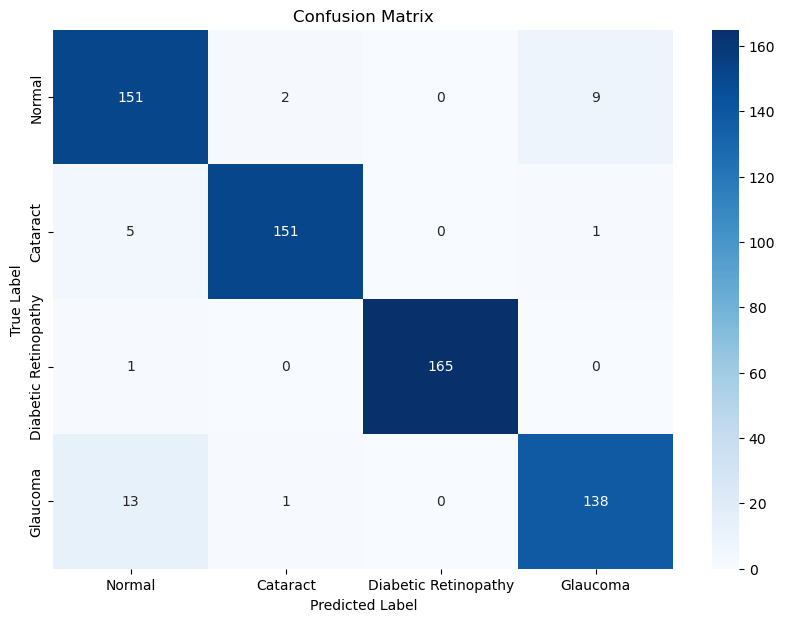

,precision,recall,f1-score,support
Normal,0.8882,0.9321,0.9096,162
Cataract,0.9805,0.9618,0.9711,157
Diabetic Retinopathy,1.0000,0.9940,0.9970,166
Glaucoma,0.9324,0.9079,0.9200,152
accuracy,0.9498,0.9498,0.9498,0
macro avg,0.9503,0.9489,0.9494,637
weighted avg,0.9507,0.9498,0.9500,637


In [201]:
# Get best model
model = create_model(_base_model, pretrained=False, classes=4, state_dict='best_vit_model_lr3e-05_b64_e7_acc94.98.pth')

# Get best and average accuracies across runs
get_accuracies_across_runs('metrics.json')

# Test the model on a new test set
df, cm = test_best_model(model)
df = df.round(4)
df["support"] = df["support"].astype(int)

visualize_consufion_matrix(cm)
df

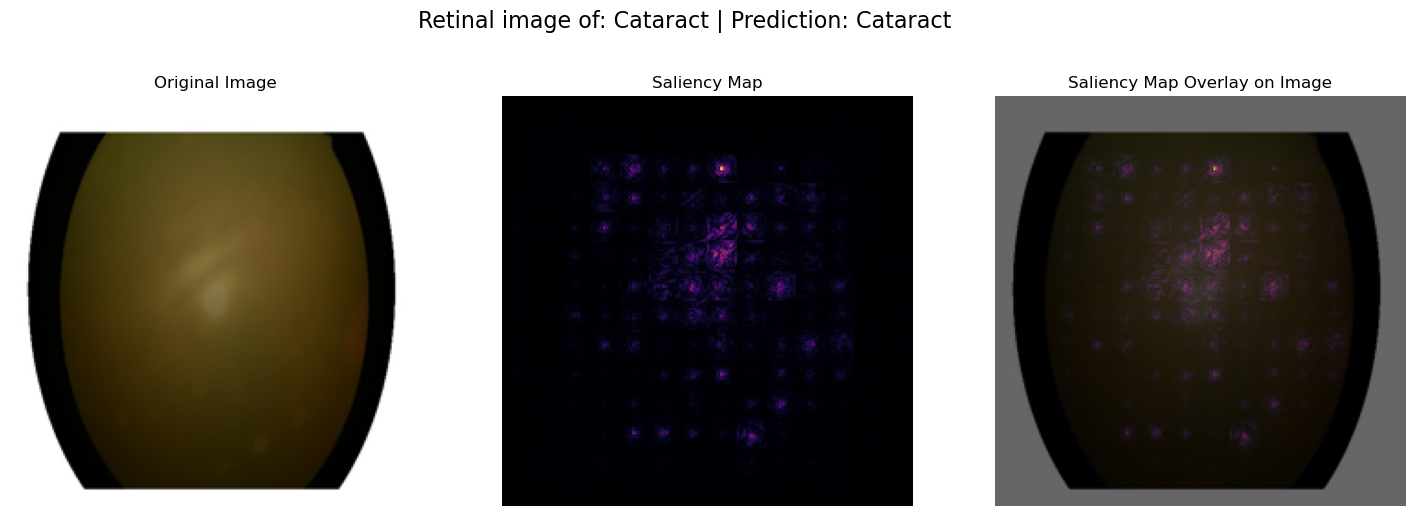

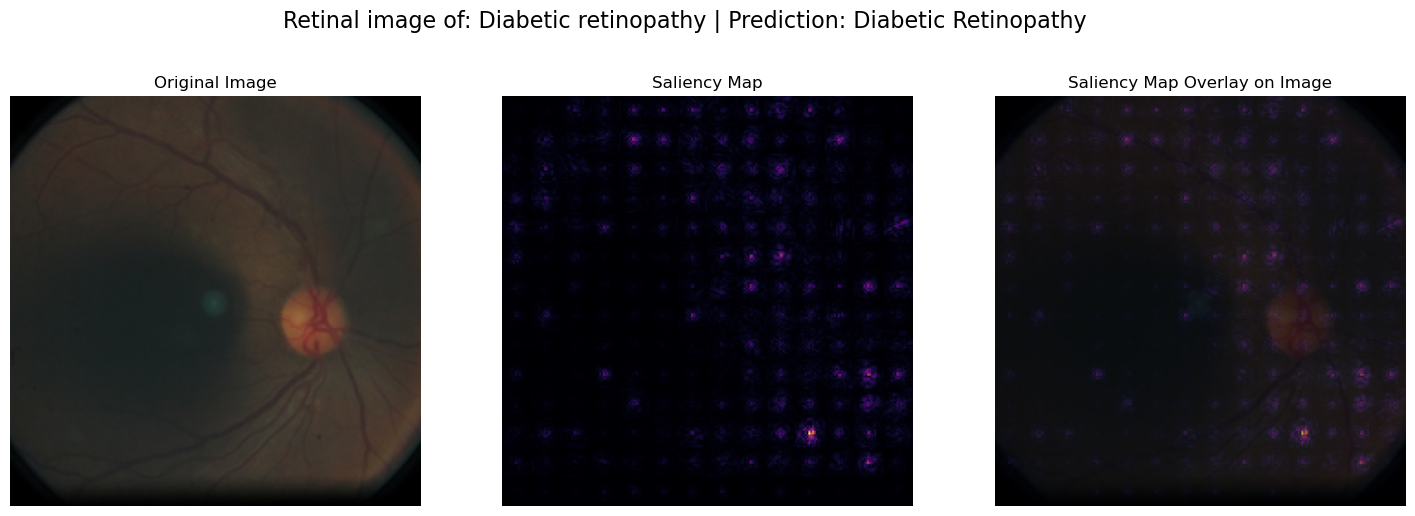

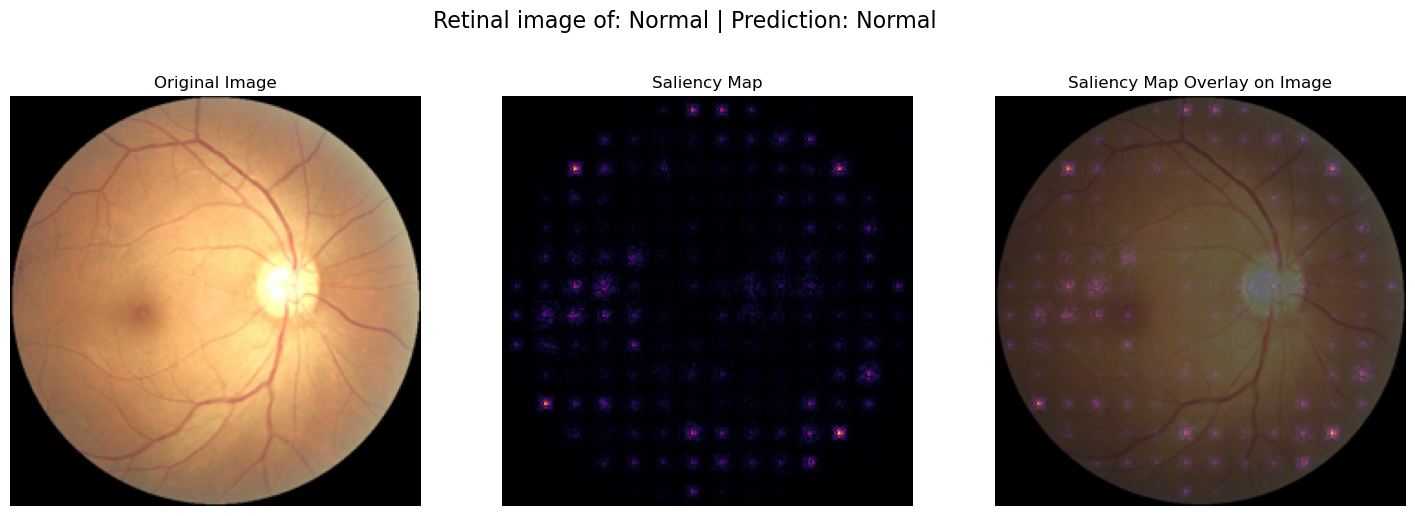

In [238]:
def visualize_saliency_for_random_images(model, count=1):
    label_map = {
       "Normal": 0, # Normal
       "Cataract": 1, # Cataract
       "Diabetic Retinopathy": 2, # Diabetic Retinopathy
       "Glaucoma": 3  # Glaucoma
   } # Map of labels to indices
    paths = ["glaucoma/g_", "diabetic_retinopathy/d_", "cataract/c_", "normal/n_"] # Paths to the images (since they're split)
    extension = [".jpg", ".png", ".jpeg"] # Possible extensions in the dataset

    for i in range(count):
        rand_value = random.randint(1, 1000) # I can make this better to include all images in a path, but this works well enough.
        rand_path = random.choice(paths)

        image_path = f"data/EDC/{rand_path}{rand_value}"

        for ext in extension:
            try:
                image = Image.open(f"{image_path}{ext}").convert("RGB")
                # Get predicted label for image
                model.eval()
                with torch.no_grad():
                    output = model(_tranform_rules(image).unsqueeze(0).to(device))
                    if isinstance(output, tuple):   # For models returning tuples
                        output = output[0]
                    pred_idx = torch.argmax(output, dim=1).item()

                # Map index to label if provided
                idx_to_label = {v: k for k, v in label_map.items()}
                prediction_label = idx_to_label.get(pred_idx, f"Class {pred_idx}")

                # Visualize the saliency map for a specific image
                label = rand_path.split("/")[0].capitalize().replace("_", " ")

                visualize_saliency_on_image(model, image, color1="inferno",label=label, prediction_label=prediction_label)
                break
            except FileNotFoundError:
                # TODO: Handle image not found across any extension (this shouldn't happen given there are no missing images & all extensions are accounted for, but this should be handled)
                continue

def visualize_saliency_for_incorrectly_predicted_images(model, path, label):
    for i in range(1,1000):
        image_path = f"data/EDC/{path}{i+1}"
        label_map = {
               "Normal": 0, # Normal
               "Cataract": 1, # Cataract
               "Diabetic retinopathy": 2, # Diabetic Retinopathy
               "Glaucoma": 3  # Glaucoma
           } # Map of labels to indices
        extension = [".jpg", ".png", ".jpeg"] # Possible extensions in the dataset
        for ext in extension:
            try:
                image = Image.open(f"{image_path}{ext}").convert("RGB")
                # Get predicted label for image
                model.eval()
                with torch.no_grad():
                    output = model(_tranform_rules(image).unsqueeze(0).to(device))
                    if isinstance(output, tuple):   # For models returning tuples
                        output = output[0]
                    pred_idx = torch.argmax(output, dim=1).item()

                # Map index to label if provided
                idx_to_label = {v: k for k, v in label_map.items()}
                prediction_label = idx_to_label.get(pred_idx, f"Class {pred_idx}")

                if prediction_label != label:
                    visualize_saliency_on_image(model, image, color1="inferno",label=label, prediction_label=prediction_label)
                    break
            except FileNotFoundError:
                continue

# visualize_saliency_for_incorrectly_predicted_images(model, "glaucoma/g_", "Glaucoma")
visualize_saliency_for_random_images(model, 3)